# Concensus clustering on Random Graphs

The graph obtained via UMAP has weights that can be interpreted as the probability of the edge’s existence. These weights can be used to generate several unweighted random graphs obtained by keeping edges with a probability proportional to their weights. We are exploring the idea of using a consensus clustering by clustering each random graph separately and see if this turns out to be a good way to obtain good clusters of the high dimensional points.

### What we want to try

* Use HDBSCAN as the final clustering
* Use connected components as the clustering of the random graphs
* Use diffusion first

## A summary of the results

Ok, so that I remember what this was all about, I will write a few results up here.

I used an ensemble of 20 members. I used different weak learners - Leiden or connected components on a graph obtained by randomly dropping edges of the original UMAP graph (the probability that an edge is kept is proportional to its UMAP weight). I combined the clusters obtained on the random graphs in a final graph where each edge is the proportion of times the two endpoints were put together in partitions of random graphs. As a final partition strategy we either use Leiden or HDBSCAN.

| Dataset | Straight Leiden | Leiden (final), Leiden (random) | HDBSCAN (final), CC (random) | HDBSCAN (final), Leiden (random) | UMAP+HDBSCAN | 
| --- | ----------- | ----------- | ----------- |----------- |----------- | 
| pendigits | 0.89/0.91 | 0.87/0.91 | 0.05/0.24 | 0.87/0.91 | 0.92/0.93 |
| coil | 0.75/0.88 | 0.76/0.89 | 0.60/0.89 | 0.81/0.95 | 0.79/0.94 |
| mnist | 0.80/0.84 | 0.76/0.83 | 0.00/0.00 | 0.57/0.70 | 0.92/0.90 |
| usps | 0.80/0.87 | 0.79/0.87 | 0.00/0.01 | 0.58/0.76 | 0.88/0.90 |
| buildings | 0.29/0.61 | 0.29/0.63 | 0.00/0.08 | 0.21/0.60 | 0.34/0.68 |

For all experiments, we removed more edges for the connected components than we did when using Leiden. 
* for Leiden: keep an edge ij if a randomly generated number between 0 and 1 is less than w_{ij}
* for CC: keep and edge ij if a randomly generated number between 0 and 1.3 is less than w_{ij}

The CC for Mnist did not work. The random graphs were not split into enough components. It varied between 1 and 11 components (mostly 4,5,6) resulting in many weight 1 edges in the final graph.

The results show that some of these combinations work well for a given example or another. But overall, straight Leiden is a better option for all graphs.

In [1]:
!git branch

  concensus
* master


In [2]:
execfile('functions/data_specifics.py')
execfile('functions/graph_functions.py')
print(data_set_list)

['pendigits', 'coil', 'mnist', 'usps', 'buildings', 'clusterable']


In [3]:
from IPython.display import display, Markdown, Latex
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import cluster

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import umap

sns.set()

In [4]:
import leidenalg as la
import igraph as ig
from tqdm import tqdm

## Get data

In [5]:
dataset_id=1
raw_data, targets, dataset_name = get_dataset(dataset_id=dataset_id)

k = get_dataset_params(dataset_id)['n_neighbors']
print(data_set_list[dataset_id])

coil


In [6]:
symmetric_graph, _, _ = umap.umap_.fuzzy_simplicial_set(raw_data, n_neighbors=k, metric="euclidean", random_state=42)
A_umap = symmetric_graph
# symmetric_graph[np.arange(symmetric_graph.shape[0]), np.arange(symmetric_graph.shape[0])] = 1.0
umap_graph = symmetric_graph.copy()
directed_graph, _, _ = umap.umap_.fuzzy_simplicial_set(raw_data, n_neighbors=k, metric="euclidean", random_state=42, apply_set_operations=False)
directed_graph = directed_graph.tocsr()

# Diffuse and prune

In [7]:
from sklearn.preprocessing import normalize
import scipy.sparse.csgraph

In [8]:
%%time
threshold = 0.01
umap_graph = normalize(directed_graph, norm="l1")
new_graph = umap_graph * umap_graph# + umap_graph
new_graph.setdiag(0)
new_graph = normalize(new_graph, norm="l1")
new_graph.data[new_graph.data < threshold] = 0.0
new_graph = normalize(new_graph, norm="l1")
new_graph.eliminate_zeros()
new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)
# new_graph = new_graph.maximum(new_graph.T)

for i in range(20):
    new_graph = umap_graph * new_graph# + umap_graph
    # new_graph = new_graph * umap_graph
    new_graph.setdiag(0)
    new_graph = normalize(new_graph, norm="l1")
    new_graph.data[new_graph.data < threshold] = 0.0
    new_graph = normalize(new_graph, norm="l1")
    new_graph.eliminate_zeros()
    new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)

    # new_graph = new_graph.maximum(new_graph.T)
    
# The new graph to the power 3 - still creating new paths
new_graph = new_graph ** 3
new_graph.data[new_graph.data < threshold] = 0.0
new_graph.eliminate_zeros()

CPU times: user 74.8 ms, sys: 0 ns, total: 74.8 ms
Wall time: 74.6 ms


/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


# Using quantiles to threshold

In [133]:
def get_data_larger_quantile(A_csr, quantile):
    row_quantiles = np.array([np.quantile(A_csr.data[A_csr.indptr[i]:A_csr.indptr[i+1]], quantile) for i in range(A_csr.shape[0])])
    data_filter = np.hstack([np.array([A_csr.data[A_csr.indptr[i]:A_csr.indptr[i+1]]>row_quantiles[i]]) for i in range(A_csr.shape[0])])[0]
    return(data_filter)

In [144]:
%%time
threshold = 0.001
quantiles = [0.2]*5 + [0.4]*5 + [0.6]*5 + [0.7]*5
umap_graph = normalize(directed_graph, norm="l1")
new_graph = umap_graph * umap_graph# + umap_graph
new_graph.setdiag(0)
new_graph = normalize(new_graph, norm="l1")
new_graph.data[new_graph.data < threshold] = 0.0
new_graph = normalize(new_graph, norm="l1")
new_graph.eliminate_zeros()
new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)
# new_graph = new_graph.maximum(new_graph.T)

for i in range(len(quantiles)):
    new_graph = umap_graph * new_graph# + umap_graph
    # new_graph = new_graph * umap_graph
    new_graph.setdiag(0)
    new_graph = normalize(new_graph, norm="l1")
    data_filter = get_data_larger_quantile(new_graph, quantile=quantiles[i])
    new_graph.data[~data_filter] = 0.0
    new_graph = normalize(new_graph, norm="l1")
    new_graph.eliminate_zeros()
    new_graph = new_graph + new_graph.T - new_graph.multiply(new_graph.T)

    # new_graph = new_graph.maximum(new_graph.T)
    
# The new graph to the power 3 - still creating new paths
new_graph = new_graph ** 3
new_graph.data[new_graph.data < threshold] = 0.0
new_graph.eliminate_zeros()

/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 1.9 s, sys: 43.8 ms, total: 1.94 s
Wall time: 1.92 s


In [145]:
print(f'{umap_graph.nnz} edges before diffusion/pruning')
print(f'{new_graph.nnz} edges after diffusion/pruning')

5760 edges before diffusion/pruning
33992 edges after diffusion/pruning


# Leiden on diffused/pruned graph

In [146]:
G_orig = ig.Graph.Adjacency(new_graph>0)
clusters_orig = la.find_partition(G_orig, la.ModularityVertexPartition).membership
max(clusters_orig)+1

22

In [147]:
ari_orig = adjusted_rand_score(targets, clusters_orig)
ami_orig = adjusted_mutual_info_score(targets, clusters_orig)
print(f'ARI = {ari_orig} and AMI = {ami_orig}') 

ARI = 0.7414817197809763 and AMI = 0.883355022137688


# Build ensemble members

We construct random graphs by flipping ( number_edges x ensemble_size) coins. Each flip determine if we keep a specific edge in a specific random graph.

In [148]:
ensemble_size = 20
number_edges = len(A_umap.data)
print(number_edges)

6590


In [15]:
coin_flips = np.random.rand(ensemble_size, number_edges)
keep_edges = coin_flips < A_umap.data
keep_edges.shape

(20, 6590)

Proportion of edges kept in each random graph

In [16]:
np.sum(keep_edges, axis=1)/number_edges

array([0.6552352 , 0.66388467, 0.6629742 , 0.65705615, 0.66616085,
       0.66145675, 0.65417299, 0.65614568, 0.65022762, 0.65371775,
       0.66009105, 0.65918058, 0.6599393 , 0.6616085 , 0.65902883,
       0.65553869, 0.65250379, 0.66373293, 0.6538695 , 0.66358118])

Number of times edges are part of the random graphs

<AxesSubplot:ylabel='Count'>

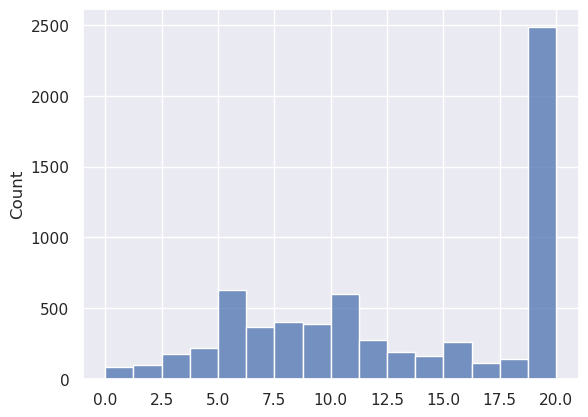

In [17]:
sns.histplot(np.sum(keep_edges, axis=0))

# Cluster the random graphs using Leiden

In [18]:
clusters = dict()
for i in tqdm(range(ensemble_size)):
    A = A_umap.copy()
    A.data = keep_edges[i]
    A.eliminate_zeros()
    G = ig.Graph.Adjacency(A, mode='undirected')
    clusters[i] = la.find_partition(G, la.ModularityVertexPartition).membership

100%|██████████| 20/20 [00:00<00:00, 41.00it/s]


In [19]:
for i in range(ensemble_size):
    print(max(clusters[i])+1)

39
38
38
37
38
34
38
39
37
40
36
38
38
37
38
40
41
37
38
38


Get the concensus counts for each row

In [21]:
A_umap_coo = A_umap.tocoo()
rows = A_umap_coo.row
cols = A_umap_coo.col
concensus_counts = np.array([0]*number_edges)
for cl in range(ensemble_size):
    concensus_counts = concensus_counts+np.array( [int(clusters[cl][rows[i]]==clusters[cl][cols[i]]) for i in range(number_edges)] )

<AxesSubplot:ylabel='Count'>

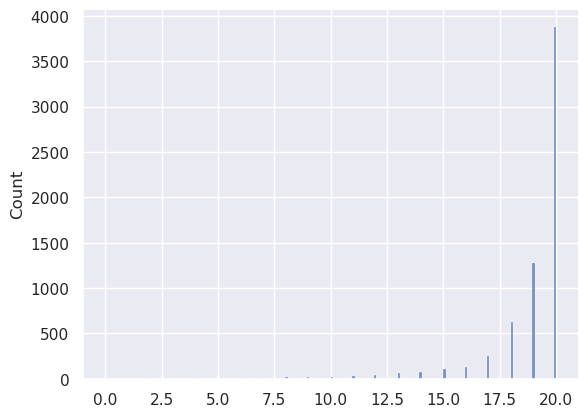

In [22]:
sns.histplot(concensus_counts)

In [23]:
A_results = A_umap_coo.copy()
A_results.data = concensus_counts/(ensemble_size+1)

# Another clustering of random graphs using connected components

In [24]:
keep_edges_cc = coin_flips < A_umap.data/1.3

In [25]:
clusters_cc = dict()
for i in tqdm(range(ensemble_size)):
    A = A_umap.copy()
    A.data = keep_edges_cc[i]
    A.eliminate_zeros()
    n_components, components = scipy.sparse.csgraph.connected_components(A)
    clusters_cc[i] = components

100%|██████████| 20/20 [00:00<00:00, 3934.43it/s]


In [26]:
for i in range(ensemble_size):
    print(max(clusters_cc[i])+1)

18
15
22
17
16
16
18
21
14
19
18
17
18
18
21
22
17
15
19
15


In [27]:
A_umap_coo = A_umap.tocoo()
rows = A_umap_coo.row
cols = A_umap_coo.col
concensus_counts_cc = np.array([0]*number_edges)
for cl in range(ensemble_size):
    concensus_counts_cc = concensus_counts_cc+np.array( [int(clusters_cc[cl][rows[i]]==clusters_cc[cl][cols[i]]) for i in range(number_edges)] )

<AxesSubplot:ylabel='Count'>

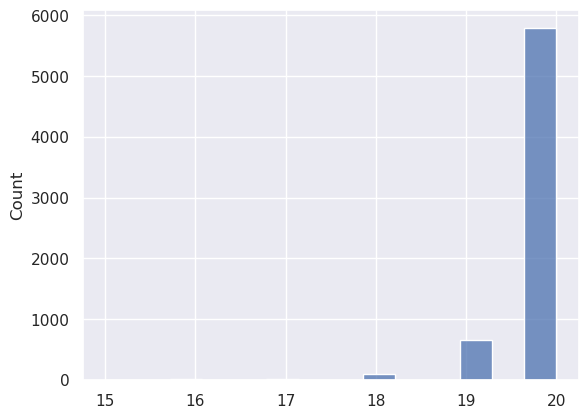

In [28]:
sns.histplot(concensus_counts_cc)

In [29]:
A_results_cc = A_umap_coo.copy()
A_results_cc.data = concensus_counts_cc/(ensemble_size+1)

# Concencus

Build a final graph with weights being equal to the proportion of times the end points of the edge were put in the same clusters.

# Evaluate final clusters with Leiden

In [45]:
G = ig.Graph.Weighted_Adjacency(A_results)
lei_labels = la.find_partition(G, la.ModularityVertexPartition, weights='weight').membership

In [46]:
print(max(lei_labels)+1)
print(max(targets)-min(targets)+1)

30
20


In [47]:
labels = lei_labels
ari_lei = adjusted_rand_score(targets, labels)
ami_lei = adjusted_mutual_info_score(targets, labels)
print(f'ARI = {ari_lei} and AMI = {ami_lei}') 

ARI = 0.7719570651320211 and AMI = 0.8923308175801956


# Evaluate final clusters with HDBSCAN

In [35]:
def hdbscan_on_graph(distance_graph):
    if scipy.sparse.csgraph.connected_components(distance_graph)[0] > 1:
        n_components, components = scipy.sparse.csgraph.connected_components(distance_graph)
        rj_labels = np.full(distance_graph.shape[0], -1, dtype=np.int64)
        for i in range(n_components):
            if np.sum(components == i) <= 90:
                subgraph_labels = np.zeros(np.sum(components == i), dtype=np.int64)
            else:
                subgraph = distance_graph[components == i, :][:, components == i]
                subgraph_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30, allow_single_cluster=subgraph.shape[0] < 300).fit_predict(subgraph)
            subgraph_labels[subgraph_labels >= 0] += (rj_labels.max() + 1)
            rj_labels[components == i] = subgraph_labels
            print(i, np.sum(components == i), Counter(subgraph_labels))
    else:
        rj_labels = hdbscan.HDBSCAN(metric="precomputed", min_samples=2, min_cluster_size=30).fit_predict(distance_graph)
    return(rj_labels)

In [36]:
import hdbscan
from collections import Counter

In [37]:
distance_graph = A_results.tocsr().copy()
# distance_graph = distance_graph + distance_graph * distance_graph + distance_graph * distance_graph * distance_graph
# distance_graph = distance_graph * distance_graph
print(np.sum(distance_graph.data > 1))
distance_graph.eliminate_zeros()
distance_graph.data = -np.log(distance_graph.data)

0


In [38]:
hdb_labels = hdbscan_on_graph(distance_graph)

0 72 Counter({0: 72})
1 72 Counter({1: 72})
2 72 Counter({2: 72})
3 72 Counter({3: 72})
4 72 Counter({4: 72})
5 504 Counter({5: 72, 8: 72, 9: 72, 13: 63, 11: 47, 12: 40, 6: 38, -1: 36, 7: 34, 10: 30})
6 72 Counter({14: 72})
7 72 Counter({15: 72})
8 72 Counter({16: 72})
9 72 Counter({17: 72})
10 72 Counter({18: 72})
11 144 Counter({19: 131, -1: 13})
12 72 Counter({20: 72})


In [39]:
ari_hdb = adjusted_rand_score(targets, hdb_labels)
ami_hdb = adjusted_mutual_info_score(targets, hdb_labels)
print(f'ARI = {ari_hdb} and AMI = {ami_hdb}') 

ARI = 0.8500358314005967 and AMI = 0.9243289204369654


With CC instead

In [40]:
distance_graph = A_results_cc.tocsr().copy()
# distance_graph = distance_graph + distance_graph * distance_graph + distance_graph * distance_graph * distance_graph
# distance_graph = distance_graph * distance_graph
print(np.sum(distance_graph.data > 1))
distance_graph.eliminate_zeros()
distance_graph.data = -np.log(distance_graph.data)

0


In [41]:
hdb_cc_labels = hdbscan_on_graph(distance_graph)

0 72 Counter({0: 72})
1 72 Counter({1: 72})
2 72 Counter({2: 72})
3 72 Counter({3: 72})
4 72 Counter({4: 72})
5 504 Counter({7: 271, 8: 74, 5: 72, 6: 72, -1: 15})
6 72 Counter({9: 72})
7 72 Counter({10: 72})
8 72 Counter({11: 72})
9 72 Counter({12: 72})
10 72 Counter({13: 72})
11 144 Counter({14: 144})
12 72 Counter({15: 72})


In [42]:
evaluate_on = ( hdb_cc_labels>=0 )
ari_hdb_cc = adjusted_rand_score(targets[evaluate_on], hdb_cc_labels[evaluate_on])
ami_hdb_cc = adjusted_mutual_info_score(targets[evaluate_on], hdb_cc_labels[evaluate_on])
print(f'ARI = {ari_hdb_cc} and AMI = {ami_hdb_cc}') 

ARI = 0.7356158995366591 and AMI = 0.9363811588284873


# Compare against UMAP+HDBSCAN

In [43]:
umap_rep = get_umap_vectors(dataset_id=dataset_id, raw_data=raw_data)
hd_umap_labels = h_dbscan(umap_rep, which_algo='hdbscan', dataset_id=dataset_id)
evaluate_on = ( hd_umap_labels>=0 ) 
ari_baseline = adjusted_rand_score(targets[evaluate_on], hd_umap_labels[evaluate_on])
ami_baseline = adjusted_mutual_info_score(targets[evaluate_on], hd_umap_labels[evaluate_on])
print(f'ARI = {ari_baseline} and AMI = {ami_baseline}') 

/work/home/vmpouli/.conda/envs/HighDimensionalClustering/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:261: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  "Graph is not fully connected, spectral embedding may not work as expected."


ARI = 0.7964599133236414 and AMI = 0.9461476533161096


In [48]:
print(f'| {data_set_list[dataset_id]} | {ari_orig:.2f}/{ami_orig:.2f} | {ari_lei:.2f}/{ami_lei:.2f} | {ari_hdb_cc:.2f}/{ami_hdb_cc:.2f} | {ari_hdb:.2f}/{ami_hdb:.2f} | {ari_baseline:.2f}/{ami_baseline:.2f} |')

| coil | 0.78/0.94 | 0.77/0.89 | 0.74/0.94 | 0.85/0.92 | 0.80/0.95 |
